In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [4]:
key = jax.random.PRNGKey(0)

In [5]:
import mrfx
from mrfx.models import GMRF, GUM
from mrfx.samplers import SpectralSamplerGMRF, FFTSamplerGMRF, GUMSampler

In [31]:
gmrf = GMRF(kappa=0.05)

In [16]:
spectral_sampler = SpectralSamplerGMRF(n_bands=10000, lx=256, ly=256)

In [17]:
key, subkey = jax.random.split(key, 2)
X = spectral_sampler.sample_image(gmrf, subkey)

In [18]:
X.shape
jnp.var(X)

Array(0.9939374, dtype=float32)

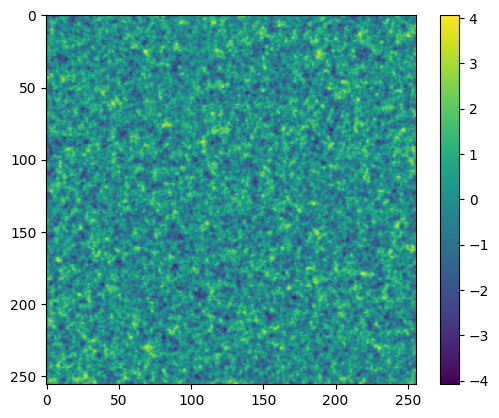

In [19]:
plt.imshow(X)
plt.colorbar()
plt.show()

In [11]:
gum = GUM(kappa=0.3, K=2, dim=2)

In [12]:
gum_sampler = GUMSampler(n_bands=5000, lx=256, ly=256, method="spectral")
key, subkey = jax.random.split(key, 2)
X, _ = gum_sampler.sample_image(gum, subkey)

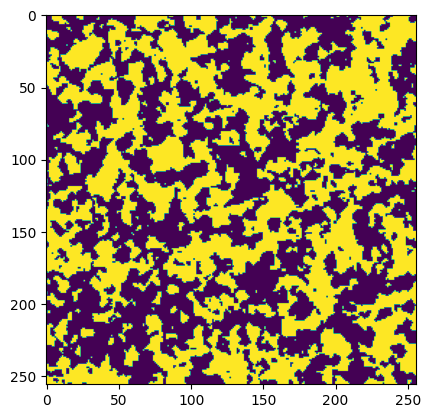

In [13]:
plt.imshow(X)
plt.show()

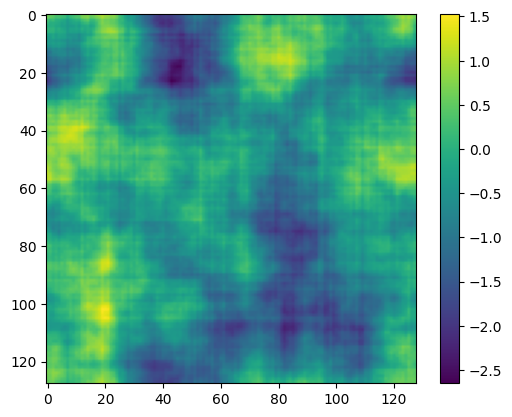

In [32]:
spectral_sampler = FFTSamplerGMRF(lx=128, ly=128)
key, subkey = jax.random.split(key, 2)
X = spectral_sampler.sample_image(gmrf, subkey)
plt.imshow(X)
plt.colorbar()
plt.show()

In [70]:
print(X)

[[-0.2909423  -0.48178124 -0.01643276 ...  0.5956477   2.394239
   1.3493549 ]
 [ 0.8954829  -0.5315922  -0.79662585 ... -1.4078988   0.2316137
   2.0418806 ]
 [ 1.5286921   0.62642336 -0.9444711  ...  1.7993872  -1.872242
  -0.24293774]
 ...
 [-0.01243925 -0.25498605 -0.9149076  ...  0.23710555  0.0667218
   0.41568452]
 [ 0.16397746 -0.191908   -0.34205237 ...  1.7024858   0.17302871
  -0.17269492]
 [-0.35963953  0.08987565 -0.17423403 ...  2.6232767   1.5624444
  -0.04565454]]


In [62]:
gum_sampler = GUMSampler(n_bands=5000, lx=128, ly=128, method="fourier")
key, subkey = jax.random.split(key, 2)
X, _ = gum_sampler.sample_image(gum, subkey)

[[1.         0.91679716 0.78170055 ... 0.64487994 0.78170055 0.91679716]
 [0.91679716 1.         0.74871904 ... 0.62374634 0.74871904 0.8628573 ]
 [0.78170055 0.74871904 1.         ... 0.56814194 0.6676303  0.74871904]
 ...
 [0.64487994 0.62374634 0.56814194 ... 1.         0.56814194 0.62374634]
 [0.78170055 0.74871904 0.6676303  ... 0.56814194 1.         0.74871904]
 [0.91679716 0.8628573  0.74871904 ... 0.62374634 0.74871904 1.        ]]
[[-2.75216341e+00  5.76486874e+00  6.27488613e-01 ...  7.64814186e+00
   7.42951989e-01  5.84135056e+00]
 [ 5.08597708e+00  2.36397600e+00 -1.27651806e+01 ...  1.12631130e+01
  -3.19262195e+00 -2.14718580e-01]
 [ 4.36752319e-01 -1.21828623e+01 -3.38519979e+00 ... -6.64863944e-01
  -1.48572540e+01 -3.10284495e+00]
 ...
 [ 7.65143299e+00  1.18077135e+01 -9.84086990e-02 ...  6.25032902e+00
   1.38860207e+01  5.76070249e-01]
 [ 2.02241182e-01 -3.22005749e+00 -1.50915699e+01 ...  1.37315845e+01
  -3.52122855e+00 -1.24636698e+01]
 [ 5.29291010e+00 -1.27410

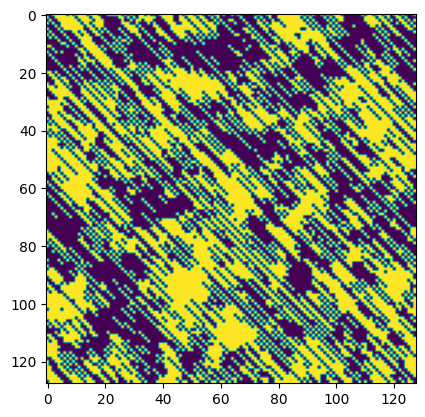

In [63]:
plt.imshow(X)
plt.show()

In [ ]:
from mrfx.models import Potts
K = 2
beta = 0.33
potts_model = Potts(K, beta)
from mrfx.samplers import GibbsSampler
key, subkey = jax.random.split(key, 2)

# Note that it is OK that Gibbs do not converge for low beta values
gibbs = GibbsSampler(256, 256, eps=0.05, max_iter=1000)
X_init, X_list, n_iter = gibbs.run(potts_model, subkey)
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(X_init, origin="lower")
axes[1].imshow(X_list[-1], origin="lower")
plt.show()

In [ ]:
plt.imshow(X_list[-1])
plt.show()

In [ ]:
import numpy as np
import time
def time_update_one_image(
    Sampler,
    Model,
    key,
    Ks,
    sizes,
    reps,
    kwargs_sampler=None,
    kwargs_model=None,
) -> list:
    """
    Get a time estimate of the call to `update_one_image` for a given sampler
    and a given model

    Parameters
    ----------
    Sampler
        A non-instantiated AbstractGibbsSampler
    Model
        A non-instantiated AbstractMarkovRandomFieldModel
    key
        A jax PRNG key
    Ks
        A list, sequence, numpy array of the numbers of classes of the model
        that we want to time
    size
        An list, sequence, array of pairs of each (lx, ly), ie. the dimensions
        over which we want to time the sampler
    reps
        An integer. The number of time sample we average for a given
        combination of K and size
    kwargs_sampler
        A dictionary with the remaining arguments needed to instanciate the
        sampler (passed as keywords arguments): all the arguments apart from
        `lx` and `ly`
    kwargs_model
        A dictionary with the remaining arguments needed to instanciate the
        model (passed as keywords arguments): all the arguments apart from
        `K`

    Note that Ks must be a numpy array (because it is passed as a static_argnum
    in the jitted functions of mrfx and jax.numpy arrays are non hashable)
    """
    Ks = np.asarray(Ks)
    times = []
    for k in Ks:
        times.append([])
        model = Model(K=k, **kwargs_model)
        for lx, ly in sizes:
            sampler = Sampler(lx=lx, ly=ly, **kwargs_sampler)

            rep_times = []
            print(f"Rep ( / {reps}), ", end="")
            key, subkey = jax.random.split(key, 2)

            # compilation
            start = time.time()
            j_sample_image = jax.jit(sampler.sample_image)
            X = j_sample_image(model=model, key=key)
            X.block_until_ready()
            end = time.time()
            compilation_time = end - start

            for r in range(reps):
                key, subkey = jax.random.split(key, 2)

                start = time.time()
                X = j_sample_image(model=model, key=key)
                X.block_until_ready()
                end = time.time()
                runtime = end - start

                rep_times.append(runtime)
                print(f"{r+1} ", end="")
            runtime_mean = np.mean(rep_times)
            print(f"\n{k=}, {lx=}, {ly=}, {compilation_time=}, {runtime_mean=}")

            times[-1].append(runtime_mean)
    return times

In [ ]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 11)
sizes = [(2 ** e, 2 ** e) for e in range(4, 9)]
times = time_update_one_image(
    Sampler=SpectralSamplerGUM,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=10,
    kwargs_sampler={"n_bands":1000},
    kwargs_model={"kappa":0.05, "dim":2},
) 

In [ ]:
from mrfx.experiments import plot_benchmark
plot_benchmark(Ks, sizes, times, title="Times for GUM sampling")